In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#!pip install scikit-learn


In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 100

In [4]:
DIRECTORY = r"C:\Hope AI\10_Deep_Learning\1. Final Project (Face Mask)\1. Final Project (Face Mask)\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

C:\Users\avata\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [10]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [17]:
# compile our model
print("[INFO] compiling model...")

from tensorflow.keras.optimizers.legacy import Adam

# Assuming INIT_LR and EPOCHS are defined somewhere in your code
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
30/30 [==============================] - 113s 4s/step - loss: 0.0578 - accuracy: 0.9849 - val_loss: 0.0481 - val_accuracy: 0.9857
Epoch 2/10
30/30 [==============================] - 103s 3s/step - loss: 0.0540 - accuracy: 0.9839 - val_loss: 0.0461 - val_accuracy: 0.9870
Epoch 3/10
30/30 [==============================] - 107s 4s/step - loss: 0.0593 - accuracy: 0.9795 - val_loss: 0.0468 - val_accuracy: 0.9870
Epoch 4/10
30/30 [==============================] - 119s 4s/step - loss: 0.0545 - accuracy: 0.9839 - val_loss: 0.0435 - val_accuracy: 0.9896
Epoch 5/10
30/30 [==============================] - 119s 4s/step - loss: 0.0524 - accuracy: 0.9832 - val_loss: 0.0370 - val_accuracy: 0.9909
Epoch 6/10
30/30 [==============================] - 141s 5s/step - loss: 0.0434 - accuracy: 0.9882 - val_loss: 0.0364 - val_accuracy: 0.9909
Epoch 7/10
30/30 [==============================] - 144s 5s/step - loss: 0.0395 - accuracy: 0.9879 - val

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("New_Face_Mask_Detector.h5")

[INFO] evaluating network...
8/8 [==============================] - 27s 3s/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770

[INFO] saving mask detector model...


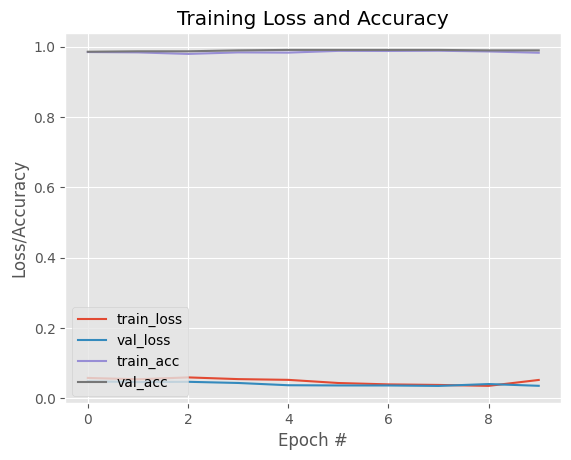

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
import os
print(os.getcwd())